In [1]:
'''author: Xiuwen & Lu'''

import numpy as np
from scipy.interpolate import make_interp_spline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_warmup as warmup

import collections
from collections import OrderedDict
from itertools import product

import pickle
import copy
import os,random
import sys
import warnings

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

sns.set_theme(style="white")  # grid
sys.setrecursionlimit(10000)
warnings.filterwarnings('ignore')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

## Kernel register

In [2]:
## extend kernel function
class KernelRegister(dict):
    def __init__(self, *args, **kwargs):
        super(KernelRegister, self).__init__(*args, **kwargs)
        self._dict = {}
    
    def register(self, target):
        def add_register_item(key, value):
            if not callable(value):
                raise Exception(f"register object must be callable! But receice:{value} is not callable!")
            if key in self._dict:
                print(f"warning: \033[33m{value.__name__} has been registered before, so we will overriden it\033[0m")
            self[key] = value
            return value

        if callable(target):      # If the target passed in is callable, it means that no registration name was given before, so we use the name of the passed-in function or class as the registration name.
            return add_register_item(target.__name__, target)
        else:                     # If it is not callable, it means that an additional name for the registered callable object was provided.
            return lambda x : add_register_item(target, x)
    
    def __call__(self, target):
        return self.register(target)
    
    def __setitem__(self, key, value):
        self._dict[key] = value

    def __getitem__(self, key):
        return self._dict[key]
    
    def __contains__(self, key):
        return key in self._dict
    
    def __str__(self):
        return str(self._dict)
    
    def keys(self):
        return self._dict.keys()
    
    def values(self):
        return self._dict.values()
    
    def items(self):
        return self._dict.items()

kernel_register = KernelRegister()


class KernelRiverElement():
    def __init__(self, kernel_list, kernel_register=kernel_register):

        self.kernel_list = kernel_list
        self.throughput = len(self.kernel_list)
        self.num_array = np.array([kernel_register[kernel_elem].param_num for \
                                    kernel_elem in kernel_list])
        self.cumsum_array = np.insert(self.num_array.cumsum(axis=0), 0, 0)
        self.fishshoal = self.num_array.sum()


"""
pattern : dim_in * dim_out

input : ... * sample * dim_in
"""

def dispatch(cls, vct):
    '''
    vct_h : [batch * 1] * input_dims(dims of input) * output_dims(dims of target features)
    vct   :      batch  * vct_nums(capacity of a set of vectors)   * input_dims(dims of input
    '''
    if cls.has_pattern:
        vct_h = cls.vct_h
    elif isinstance(vct, tuple):
        vct_h, vct = vct
        vct_h = vct_h.transpose(-1,-2) [...,None,:,:]
    else:
        vct_h = vct.transpose(-1,-2) [...,None,:,:]
    return vct_h, vct

def norm_measure(vct_h, vct):
    diff = vct_h - vct[...,None]

    norm = torch.linalg.norm(diff, dim=-2)
    return norm

def innerprod_measure(vct_h, vct):
    vct_h = vct_h.squeeze(dim=-3)
    inner = torch.matmul(vct, vct_h).squeeze(0)
    return inner

## Define and register kernel function

Following we take Gaussian and Laplacian kernels as example, and more kernels can copy from kernel_zoo.py

In [3]:
# Gaussian kernel
@kernel_register.register('gaussian')
class gaussian_kernel_layer(nn.Module):
    param_num = 1
    def __init__(self, input_dims=1, output_dims=1, has_pattern=False, **kwargs):
        super(gaussian_kernel_layer, self).__init__()
        self.has_pattern = has_pattern
        if self.has_pattern:
            self.vct_h = nn.Parameter(torch.ones((input_dims, output_dims)), requires_grad=True)
        self.ori_kernel_fish_posnum = nn.Parameter(torch.tensor(1.2), requires_grad=True)
    
    def forward(self, vct):
        vct_h, vct = dispatch(self, vct)
        norm = norm_measure(vct_h, vct)
        quad = norm**2

        kernel_matrix = torch.exp(-quad/(2*self.ori_kernel_fish_posnum**2 + 1e-40))

        return kernel_matrix



## Define Regular Kernel Flow

The type of kernel flows is controled by lasso_gamma: if lasso_gamma > 0, the method is Sparse KFs; if lasso_gamma = 0, the method is Regular Kfs

In [4]:
dc = copy.deepcopy 

# Calculate Horsdorff distance
def torch2D_Hausdorff_distance(x,y): # Input be like (Batch,width,height)
    x = x.float()
    y = y.float()
    distance_matrix = torch.cdist(x,y,p=2) # p=2 means Euclidean Distance
    
    value1 = distance_matrix.min(2)[0].max(1, keepdim=True)[0]
    value2 = distance_matrix.min(1)[0].max(1, keepdim=True)[0]
    
    value = torch.cat((value1, value2), dim=1)
    
    return value.max(1)[0]

# Kernel layer
# outdim * indim
class RiverLayer(nn.Module):
    """
    input: B * Time * Dim
    output: B * Time * outDim
    """
    def __init__(self, input_dims=1, output_dims=1, has_pattern=False, \
                 kernelriver=KernelRiverElement(['gaussian']), **kwargs):
        """
        param
        river_bed_kernel_weight_posnorm : weight of kernel flow
        river_fish : parameters of kernel function
        river_kernel : contains diverse kernels
        """
        super(RiverLayer, self).__init__()

        self.has_pattern = has_pattern
        self.input_dims = input_dims
        self.output_dims = output_dims

        self.riverkernel = nn.ModuleList([kernel_register[kernel_layer](input_dims=self.input_dims, \
                                            output_dims=self.output_dims, has_pattern=self.has_pattern,  **kwargs) \
                                            for kernel_layer in kernelriver.kernel_list])
    
    def forward(self, x):
        x = torch.stack(tuple(k_river(x) for k_river in self.riverkernel), axis=-1)
        return x


## Kernel Flows
class RegularKernelFlow(nn.Module):
    '''
    Class of KernelFlow
    func
    - forward : calculate forward flow
    - gaming_* : methods for KF's loss
    - prepare_gram : get inverse matrix
    - predict : prediction part
    '''
    def __init__(self, init_data, \
                 Lambda = 0.000025, \
                 sample_ratio=0.5,\
                 kernelriver=KernelRiverElement(['gaussian']), **kwargs):
        """
        """
        
        super(RegularKernelFlow, self).__init__()

        self.sample_ratio = sample_ratio

        ## eq5q
        self.init_data_x, self.init_data_y = init_data
        self.dims = self.init_data_x.shape[-1]
        self.input_steps = self.init_data_x.shape[-2]
        self.init_sample_nums = self.init_data_x.shape[-3]
        self.Lambda = Lambda
        self.K_eye = torch.eye(self.init_sample_nums, device=self.init_data_x.device)
        
        self.riverbed_kernel_weight_posnorm = nn.Conv1d(in_channels=kernelriver.throughput, out_channels=1,\
                                 kernel_size=1, stride=1, padding=0, )
        self.gram_kernel_layer = RiverLayer(kernelriver=kernelriver, **kwargs)
        self.mult = torch.ones(1,requires_grad=True).to(device=self.init_data_x.device)

    def prepare_gram(self):
        K_ff = self.riverbed_kernel_weight_posnorm(self.gram_kernel_layer(self.init_data_x.\
                                            view(self.init_data_x.shape[0],-1)).transpose(-1,-2)).\
                                            squeeze(dim=-2) + self.K_eye * self.Lambda
        
        self.gram_matrix_inv = torch.linalg.pinv(K_ff)
    
    def predict(self, _x):
        # prepare K_fy by kernel function
        K_fy = self.gram_kernel_layer((_x.view(_x.shape[0],-1), \
                                 self.init_data_x.view(self.init_data_x.shape[0],-1)))
        # K_fy_unit = torch.matmul(K_fy, self.riverbed_kernel_weight_posnorm)
        K_fy_unit = self.riverbed_kernel_weight_posnorm(K_fy.transpose(-1,-2)).squeeze(dim=-2)
        atten_power = torch.matmul(K_fy_unit.transpose(-1,-2), self.gram_matrix_inv)
        preds = torch.matmul(atten_power, self.init_data_y[...,None].\
                             permute(1,2,0,3)).squeeze(dim=-1).permute(-1,0,1)
        return preds
    
    # kernelflow loss
    @staticmethod
    def gaming_rho(model_out):
        _y, _y_hat, _y_sample, _y_hat_sample, K_fy_sample = model_out
        _y_hat = _y_hat.squeeze(dim=-1).permute(-1,-3,-2)
        _y_hat_sample = _y_hat_sample.squeeze(dim=-1).permute(-1,-3,-2)
        gaming_a = torch.tensordot(_y, _y_hat, dims=([0,1],[0,1]))
        gaming_b = torch.tensordot(_y_sample, _y_hat_sample, dims=([0,1],[0,1]))
        return (1 - gaming_b/gaming_a).sum() #torch.abs(gaming_a - gaming_b).sum() #
    
    @staticmethod
    def gaming_rho_sqr(model_out):
        _y, _y_hat, _y_sample, _y_hat_sample, K_fy_sample = model_out
        _y_hat = _y_hat.squeeze(dim=-1).permute(-1,-3,-2)
        _y_hat_sample = _y_hat_sample.squeeze(dim=-1).permute(-1,-3,-2)
        gaming_a = torch.tensordot(_y, _y_hat, dims=([0,1],[0,1]))
        gaming_b = torch.tensordot(_y_sample, _y_hat_sample, dims=([0,1],[0,1]))
        return ((gaming_a - gaming_b)**2).sum()/gaming_b.shape[0]
    
    @staticmethod
    def gaming_rho_hausdorff_pred(model_out):
        _y, _y_hat, _y_sample, _y_hat_sample, K_fy_sample = model_out
        gaming_a = _y
        gaming_b = torch.matmul(K_fy_sample, _y_hat_sample).\
            squeeze(dim=-1).permute(-1,-3,-2)
        return torch2D_Hausdorff_distance(gaming_a.permute(-2,-3,-1), gaming_b.permute(-2,-3,-1)).mean()
    
    @staticmethod
    def gaming_rho_pred(model_out):
        _y, _y_hat, _y_sample, _y_hat_sample, K_fy_sample = model_out
        gaming_a = _y
        gaming_b = torch.matmul(K_fy_sample, _y_hat_sample).\
            squeeze(dim=-1).permute(-1,-3,-2)
        return (1 - gaming_b/gaming_a).sum()
    
    @staticmethod
    def gaming_rho_sqr_pred(model_out):
        _y, _y_hat, _y_sample, _y_hat_sample, K_fy_sample = model_out
        gaming_a = _y
        gaming_b = torch.matmul(K_fy_sample, _y_hat_sample).\
            squeeze(dim=-1).permute(-1,-3,-2)
        return ((gaming_a - gaming_b)**2).sum()/gaming_a.shape[0]

    def forward(self, _x, _y):
        """
        _x :                    batch     *  input_steps  *  dims
        self.init_data_x :      init_len  *  input_steps  *  dims
        self.init_data_y :      init_len  *   pred_steps  *  dims
        """

        batch_num = _x.shape[0]
        sample_num = int(batch_num * self.sample_ratio)
        K_eye_batch = torch.eye(batch_num, device=self.init_data_x.device)
        assert sample_num > 0

        index = torch.LongTensor(random.sample(range(batch_num), sample_num)).to(device=_x.device)

        _x_sample = torch.index_select(_x, 0, index)
        _y_sample = torch.index_select(_y, 0, index)

        K_ff = self.riverbed_kernel_weight_posnorm(self.gram_kernel_layer(_x.view(_x.shape[0],-1)).transpose(-1,-2)).\
                            squeeze(dim=-2) + K_eye_batch * self.Lambda


        K_ff_sample = torch.index_select(torch.index_select(K_ff, 0, index),1,index)

        K_ff_inv = torch.linalg.pinv(K_ff)
        K_ff_sample_inv = torch.linalg.pinv(K_ff_sample)

        _y_hat = torch.matmul(K_ff_inv, _y[...,None].permute(1,2,0,3))
        _y_hat_sample = torch.matmul(K_ff_sample_inv, _y_sample[...,None].permute(1,2,0,3))

        K_fy_sample = self.riverbed_kernel_weight_posnorm(self.gram_kernel_layer((_x_sample.view(_x_sample.shape[0],-1), \
                                    _x.view(_x.shape[0],-1))).transpose(-1,-2)).squeeze(dim=-2)

        '''
        _y : batch of target values 
        _y_hat : K^-1 * _y
        _y_sample : batch of samplings
        _y_hat_sample : K^-1 * _y sampling
        K_fy_sample : K_fy sampling
        '''
        return _y, _y_hat, _y_sample, _y_hat_sample, K_fy_sample

## DataLoader of chaos system 

Here we use a pre-calculated benchmark database, including 133 dynamical systems.

In [5]:
class ChaosDataSet(Dataset):
    def __init__(self, all_trajectories, CFG=None, transform=None, irregular_delay=None):
        
        self.system_data = all_trajectories[CFG.system_name] # shape: points*dims
        if CFG.normalized_type == 'zscore':
            self.system_data = (self.system_data-\
                                self.system_data.mean(axis=0))/(self.system_data.std(axis=0))
        elif CFG.normalized_type == 'minmax':
            self.system_data = (self.system_data-self.system_data.min(axis=0))/\
                (self.system_data.max(axis=0)-self.system_data.min(axis=0))
            pass
        self.transform = transform
        self.input_len = CFG.input_len
        self.pred_len = CFG.pred_len
        self.noise_type = CFG.noise_type
        self.noise_pct = CFG.noise_pct
        self.sysdata_shape = self.system_data.shape
        self.irregular_delay = irregular_delay
        self.device = CFG.device
        
        self.system_data = self.add_noise()
        self.system_data = torch.from_numpy(self.system_data).\
            to(device=self.device, dtype=torch.float)
        
        self.sysdata_x, self.sysdata_y = self.prepare_data()
        
        
    def add_noise(self):
        if self.noise_type is None:
            return self.system_data
        else:
            pass
        
        if self.noise_type == 'Gaussian':
            noise = np.random.randn(*self.sysdata_shape)
            noise = noise * (self.system_data.std(axis=0)) *\
                self.noise_pct
        elif self.noise_type == 'Laplace':
            noise = np.random.laplace(0, 1, self.sysdata_shape)
            noise = noise * (self.system_data.std(axis=0)) *\
                self.noise_pct
        else:
            noise = np.zeros(self.sysdata_shape)
            
        # noise = torch.from_numpy(noise).to(device=self.device)
        return self.system_data + noise
        
    def prepare_data(self):
        data = self.system_data
        input_len = self.input_len
        pred_len = self.pred_len
        if self.irregular_delay is not None:
            data = torch.concatenate((data, self.irregular_delays[...,None]), -1)
        
        X = torch.zeros((data.shape[0]-input_len-pred_len+1, input_len, data.shape[1])).\
            to(device=data.device)
        for i in range(X.shape[0]):
            X[i] = data[i:(i+input_len)]
            
        Y = torch.zeros((data.shape[0]-input_len-pred_len+1, pred_len, data.shape[1])).\
            to(device=data.device)
        for i in range(Y.shape[0]):
            Y[i] = data[(i+input_len):(i+input_len+pred_len)]
        
        return X, Y
    
    def sample_data(self, sample_ratio):
        N = self.sysdata_x.shape[0]
        S = int(N*sample_ratio)
        index = torch.LongTensor(random.sample(range(N), S)).to(device=self.sysdata_x.device)
        sample_x = torch.index_select(self.sysdata_x, 0, index)
        sample_y = torch.index_select(self.sysdata_y, 0, index)
        return sample_x, sample_y
    
    def sequen_split_data(self, start=0, point_num=1000, frac_ratio=0.6):
        N = min(self.sysdata_x.shape[0], point_num)
        S = int(N*frac_ratio)
        true_seq_pre = self.sysdata_y[start:start+S,...]
        true_seq = self.sysdata_y[start+S-1:start+N,...]
        model_seq = self.sysdata_x[start+S-1:start+N,...]
        return true_seq_pre, true_seq, model_seq
        
    def __len__(self):
        assert self.sysdata_x.shape[0] == self.sysdata_y.shape[0]
        return self.sysdata_x.shape[0]
    
    def __getitem__(self, index):
        x = self.sysdata_x[index,:]
        y = self.sysdata_y[index,:]
        return x, y

## Training loop

In [6]:
## regularization
def regularization_loss(model):
    loss_l1 = 0
    loss_l2 = 0
    for name, param in model.named_parameters():
                    if "_kernel_gram" in name:
                        loss_l2 += torch.sum(param**2)/2
                    elif "_kernel_weight_posnorm" in name:
                        loss_l1 += torch.sum(torch.abs(param))
                        loss_l2 += torch.sum(param**2)/2
    return loss_l1, loss_l2

## limit weight coefficients to a finite intervel
def exp_clamp_(model):
    for name,param in model.named_parameters():
        # if name.endswith('posnorm'):
        #     param.data.clamp_(0, 99)
        if ('_pos' in name) & (not '_clamp_min' in name) & \
            (not '_clamp_max' in name):
            for name_search,param_search in model.state_dict().items():
                if name + '_clamp_min' in name_search:
                    min_searched = param_search.data
                else:
                    min_searched = 1e-16
                if name + '_clamp_max' in name_search:
                    max_searched = param_search.data
                else:
                    max_searched = None
            param.data.clamp_(min=min_searched, max=max_searched)

## selection of loss function
def loss_sele(CFG):
    loss_fn_list = []
    if CFG.model_name in ['RegularKF',]:
        if CFG.kf_metric == 'rho':
            rho_fn = RegularKernelFlow.gaming_rho
        elif CFG.kf_metric == 'rho(mse)':
            rho_fn = RegularKernelFlow.gaming_rho_sqr
        elif CFG.kf_metric == 'rho(hausdorff)':
            rho_fn = RegularKernelFlow.gaming_rho_hausdorff_pred
        elif CFG.kf_metric == 'rho_pred':
            rho_fn = RegularKernelFlow.gaming_rho_pred
        elif CFG.kf_metric == 'rho_sqr_pred':
            rho_fn = RegularKernelFlow.gaming_rho_sqr_pred
        else:
            raise
        loss_fn_list.append(rho_fn)

    return loss_fn_list

## logic of loss backpropagation
def loss_backward(flow, future_flow, model, loss_fn, optimizer, CFG=None, mode='kernel'):

    if CFG.model_name in ['RegularKF',]:
        model_out = model(flow, future_flow)
        loss_l1, loss_l2 = regularization_loss(model)
        if mode.startswith('nograd'):
            if mode == 'nograd_kernel':
                with torch.no_grad():
                    loss = loss_fn(model_out) + \
                        CFG.Lambda * loss_l2 + CFG.Gamma * loss_l1
                    return loss
        if mode == 'kernel':
            loss = loss_fn(model_out) + \
                    CFG.Lambda * loss_l2 + CFG.Gamma * loss_l1
            
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

## training loop
def training_loop_kf(n_epochs, model, optimizer, optimizer_kernel, train_loader, test_loader, \
                  CFG=None):

    if CFG.is_warmup:
        num_steps = len(train_loader) * n_epochs
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_steps)
        warmup_scheduler = warmup.UntunedExponentialWarmup(optimizer)
        lr_scheduler_kernel = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_kernel, T_max=num_steps)
        warmup_scheduler_kernel = warmup.UntunedExponentialWarmup(optimizer_kernel)
    
    loss_fn_list = loss_sele(CFG)
    assert len(loss_fn_list) >= 1
    if len(loss_fn_list) == 1:
        rho_fn = loss_fn_list[0]
    else:
        loss_fn, rho_fn = loss_fn_list
        
    train_rho_list, eval_rho_list = [], []

    for epoch in range(1, n_epochs + 1):
        train_rho_sum, eval_rho_sum = 0.0, 0.0

        if (epoch % 5 == 0) & (epoch<36):
            for name, param in model.named_parameters():
                if ("_kernel_fish" in name) | ("_kernel_gram" in name): 
                    param.requires_grad = False
                else:
                    param.requires_grad = True
            optimizer_now = optimizer
        else:
            for name, param in model.named_parameters():
                param.requires_grad = True
            optimizer_now = optimizer_kernel  


        # train
        for i, (flow, future_flow) in enumerate(train_loader):    
            torch.cuda.empty_cache()

            train_rho = loss_backward(flow, future_flow, model, \
                                            rho_fn, optimizer_now, \
                                            CFG=CFG, mode='kernel')
            train_rho_list.append(train_rho.detach().cpu().numpy())

            exp_clamp_(model)
            
            train_rho_sum += train_rho.data

            if CFG.is_warmup:
                with warmup_scheduler.dampening():
                    lr_scheduler.step()
                with warmup_scheduler_kernel.dampening():
                    lr_scheduler_kernel.step()

        model.eval()

        for  i, (flow, future_flow) in enumerate(test_loader):
            torch.cuda.empty_cache()

            eval_rho = loss_backward(flow, future_flow, model, \
                                            rho_fn, optimizer_now, \
                                            CFG=CFG, mode='nograd_kernel')
            eval_rho_list.append(eval_rho.detach().cpu().numpy())
            eval_rho_sum += eval_rho.data

        if epoch == 1 or epoch % 10 == 0:
            print(f'Epoch: {epoch}, Train: ({train_rho_sum/len(train_loader)}), Eval: ({eval_rho_sum/len(test_loader)})')

    train_linspace = np.linspace(1, 1+len(train_rho_list), len(train_rho_list))
    eval_linspace = np.linspace(1, 1+len(train_rho_list), len(eval_rho_list))+len(train_loader)
    train_performance = np.array([train_rho_list,])
    eval_performance = np.array([eval_rho_list,])

    loss_plot_ser = collections.OrderedDict()
    loss_plot_ser['train'] = {}
    loss_plot_ser['train']['ser'] = [train_linspace, train_performance]
    loss_plot_ser['eval'] = {}
    loss_plot_ser['eval']['ser'] = [eval_linspace, eval_performance]

    return loss_plot_ser

## Some utility functions and experimental configuration

In [7]:
def exp_mkdir(path):
    if os.path.isdir(path):
        pass
    else:
        os.makedirs(path)

class config(OrderedDict):
    """
    Makes a  dictionary behave like an object,with attribute-style access.
    """
    def __getattr__(self,name):
        try:
            return self[name]
        except:
            raise AttributeError(name)
    def __setattr__(self,name,value):
        self[name]=value

    def cfg_exp(self, need_list=None):
        if need_list is None:
            return '_'.join([f'{keyi}({valuei})' for \
                             keyi, valuei in self.items()])
        else:
            return '_'.join([f'{keyi}({valuei})' for \
                             keyi, valuei in self.items() if \
                             keyi in need_list])

class ExpConfigManager():
    def __init__(self, exp_config_field):
        self.exp_config_field = exp_config_field
    
    def exp_gen(self, exp_list=None):
        if (exp_list is None):
            cfg_keys =  self.exp_config_field.keys()
            cfg_values_field = self.exp_config_field.values()
            for cfg_values in product(*cfg_values_field):
                dict_ori = OrderedDict({key_i:value_i for key_i, value_i in zip(cfg_keys, cfg_values)})
                cfg = config(dict_ori)
                yield cfg
        else:
            raise

## prepare training testing and ploting data
def data_prepare(data, CFG=None, is_seq=True):
    init_data = data.sample_data(CFG.init_ratio)
    if is_seq:
        seq_data = data.sequen_split_data(20, CFG.seq_lenplot, 0.65)
        true_seq_ori_pre, true_seq_ori, model_seq_ori = seq_data
    else:
        true_seq_ori_pre, true_seq_ori, model_seq_ori = [None,None,None]
    train_size = int(len(data) * CFG.train_ratio)
    test_size = len(data) - train_size

    train_dataset, test_dataset = random_split(data, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=True)

    return init_data, true_seq_ori_pre, true_seq_ori, model_seq_ori, train_loader, test_loader

def seed_torch(seed=42):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # forbiden hash randomlization, making the simulation reproducible
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed)

expconfig_field = collections.OrderedDict({
    "seed" : [42,],         # set random seeds
    "device" : [torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),],  # decide calculation by CPU or GPU
    "exp_name" : ['exp_test0606',],     # experimential name
    "exp_path" : ['./exp_results/',],
    "system_name" : ["Lorenz"],         # name of dynamical system
    "model_name" : ['RegularKF',],      # kernel learning method
    "normalized_type" : ['zscore',],    # normalization type, including 'zscore' and 'minmax' normalization
    "batch_size" : [100,],              # number of samples for calculating the denominator of $rho$ in the KFs algorithm
    "input_len" : [2,],                 # value of $tau$
    "pred_len" : [1,],                  # prediction length
    "init_ratio" : [0.33,],             # calulation for inverse matrix
    "train_ratio" : [0.80,],            # proportion of training set
    "learning_rate" : [1e-2,],          # learning rate
    "is_warmup" : [True,],              # whether to use warmup
    "seq_lenplot" : [3000,],            # number of plot
    "noise_type" : ['Gaussian_noise',], # noise type
    "noise_pct" : [0,],                 # noise level (percentage)
    "kf_metric" : ["rho"],              # the type of loss function in KFs, such as rho and hausdorff
    "Gamma" : [0.05,],                  # hyper-paramter of L1 regularization, gamma = 0 means regular kfs 
    "Lambda" : [0,],                    # hyper-parameter of L2 regularization

})

exp_cfggen = ExpConfigManager(expconfig_field)
exp_focus_list = ["system_name","model_name", "kf_metric","Gamma"]
i = 0
CFG = next(exp_cfggen.exp_gen())

CFG.exp_focus_list = exp_focus_list
model_path = CFG.exp_path + CFG.exp_name + '/model_checkpoint/'
results_path = CFG.exp_path + CFG.exp_name + '/results/'
exp_mkdir(model_path)
exp_mkdir(results_path + 'pictures/')
exp_mkdir(results_path + 'statistic/')

CFG.model_file_exp = model_path + CFG.cfg_exp(CFG.exp_focus_list)
CFG.pic_file_exp = results_path + 'pictures/' + CFG.cfg_exp(CFG.exp_focus_list)
CFG.stat_file_exp = results_path + 'statistic/' + CFG.cfg_exp(CFG.exp_focus_list)
seed_torch(CFG.seed)
print((i, CFG.system_name))

(0, 'Lorenz')


## Processing
### 1.Read data

In [8]:
point_num=6000
with open (f'./data/all_trajectories_{point_num}_pts.pkl','rb') as data_file:
    all_trajectories = pickle.load(data_file)

In [9]:
data = ChaosDataSet(all_trajectories, CFG=CFG)
data_batch = DataLoader(data, batch_size=CFG.batch_size, shuffle=True)
init_data, true_seq_ori_pre, true_seq_ori, model_seq_ori, \
            train_loader, test_loader = data_prepare(data, CFG=CFG)

### 2. KernelFlow model

In [10]:
kernelriver = KernelRiverElement(['gaussian','laplacianl1',])    # pick kernels from kernel_zoo.py
model = RegularKernelFlow(init_data=init_data, sample_ratio=0.5,\
                            kernelriver=kernelriver).to(device=CFG.device)

### 3. Training

In [11]:
for name, param in model.named_parameters():
    param.requires_grad = True
optimizer_kernel = optim.Adam(filter(lambda p: p.requires_grad, \
                            model.parameters()), lr=CFG.learning_rate)

for name, param in model.named_parameters():
    if ("_kernel_fish" in name) | ("_kernel_gram" in name):
        param.requires_grad = False
    elif "_kernel_weight_posnorm" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

optimizer = optim.Adam(filter(lambda p: p.requires_grad, \
                            model.parameters()), lr=CFG.learning_rate)   

In [12]:
loss_dict = training_loop_kf(
                n_epochs = 50,
                model = model,
                optimizer = optimizer,
                optimizer_kernel = optimizer_kernel,
                train_loader = train_loader,
                test_loader = test_loader,
                CFG = CFG,
                )

Epoch: 1, Train: (-2.3048737049102783), Eval: (5.924027442932129)
Epoch: 10, Train: (-1.0744082927703857), Eval: (-0.6992954611778259)
Epoch: 20, Train: (1.6924238204956055), Eval: (3.1951498985290527)
Epoch: 30, Train: (2.125782012939453), Eval: (56.16957092285156)
Epoch: 40, Train: (65.75990295410156), Eval: (1.8184884786605835)
Epoch: 50, Train: (0.1403133124113083), Eval: (68.93537139892578)


### 4. Eval mode 

In [13]:
model.eval()
# inverse matrix
model.prepare_gram()
pred_seq = model.predict(model_seq_ori)

### 5. Results plot and save

In [14]:
color_list = [('#00A19D','#E05D5D'), ('#1E3B7A','#CA462F'), ('#153C46','#EE781F'),\
              ('#80A492','#D23918'), ('#5F479A','#A59ACA'), ('#153C46','#F9B800'),\
              ('#426666','#C3272B'), ('#2C2F3B','#FAC03D'), ('#535386','#FFD301'),\
              ('#014946','#8F3430'), ('#283C63','#AC7088'), ('#C82423','#2878B5'),\
              ('#253659','#BF665E'), ('#2C3359','#F2BE5C'), ('#695173','#F2C9E0'),\
              ('#2C3359','#F2BE5C')]

def sys_plot_phase(sys_dict, title=None, save_path=None):
    """
    data_ser : time_point * dims
    """
    label_map = {"Actual":"Actual", "Actual_comp":"Actual", "Predicted":"Predicted", "Error":"Error"}
    smooth_ser_dict = {}
    tse = 2
    lse = 22
    fig = plt.figure(figsize=((lse+tse+18)/2,(15+tse)/2), constrained_layout=True,)
    for item in sys_dict.keys():
        data_ser = sys_dict[item]['ser']
        color_ser = sys_dict[item]['color']

        ser_len = data_ser.shape[0]
        t = np.linspace(0, 1, ser_len)
        span_num = 10
        t_smooth=np.linspace(0, 1, ser_len*span_num)
        bspl = make_interp_spline(t, data_ser, k=5, axis=0)
        ser_smooth=bspl(t_smooth)
        smooth_ser_dict[item] = {}
        smooth_ser_dict[item]['ser'] = ser_smooth
        smooth_ser_dict[item]['color'] = color_ser
    
    smooth_ser_dict['Error'] = {}
    smooth_ser_dict['Error']['ser'] = smooth_ser_dict["Actual_comp"]['ser'] - smooth_ser_dict["Predicted"]['ser']
    smooth_ser_dict['Error']['color'] = "#116A7B"

    gs = GridSpec(15+tse, lse+15+1+tse, figure=fig)

    ax1 = fig.add_subplot(gs[0+tse:5+tse, 0:lse])
    ax2 = fig.add_subplot(gs[5+tse:10+tse, 0:lse])
    ax3 = fig.add_subplot(gs[10+tse:15+tse, 0:lse])
    ax4 = fig.add_subplot(gs[1:15+tse, lse:lse+15+tse-1], projection='3d')
    ax5 = fig.add_subplot(gs[15+tse-1:15+tse, lse+15+tse-1:lse+15+tse])
    
    for item in smooth_ser_dict.keys():
        data_ser = smooth_ser_dict[item]['ser']
        color_ser = smooth_ser_dict[item]['color']
        x_smooth = data_ser[:,0]
        y_smooth = data_ser[:,1]
        z_smooth = data_ser[:,-1]
        # if item != "Actual_comp":
        #     ax4.plot(x_smooth, y_smooth, z_smooth,\
        #              color=color_ser, label=label_map[item])
        if item == 'Error':
            pass

        elif item != "Actual":
            ax1.plot(x_smooth[0::span_num],color=color_ser, label=label_map[item])
            ax2.plot(y_smooth[0::span_num],color=color_ser, label=label_map[item])
            ax3.plot(z_smooth[0::span_num],color=color_ser, label=label_map[item])
            ax4.plot(x_smooth, y_smooth, z_smooth,\
                     color=color_ser, label=label_map[item])
            # ax5.plot(z_smooth,color=color_ser, label=label_map[item])

    ax4.set_xlabel('$x$', fontsize=22)
    ax4.set_ylabel('$y$', fontsize=22)
    ax4.set_zlabel('$z$', fontsize=22)
    ax4.tick_params(axis='x',labelsize=16)
    ax4.tick_params(axis='y',labelsize=16)
    ax4.tick_params(axis='z',labelsize=16)

    ax1.set_ylabel('$x$', fontsize=22)
    ax2.set_ylabel('$y$', fontsize=22)
    ax3.set_ylabel('$z$', fontsize=22)

    ax1.tick_params(axis='y',labelsize=16)
    ax2.tick_params(axis='y',labelsize=16)
    ax3.tick_params(axis='y',labelsize=16)
    ax1.tick_params(axis='x',labelsize=16)
    ax2.tick_params(axis='x',labelsize=16)
    ax3.tick_params(axis='x',labelsize=16)

    ax5.set_xticks([])
    ax5.set_yticks([])
    ax5.spines['top'].set_visible(False)
    ax5.spines['bottom'].set_visible(False)
    ax5.spines['left'].set_visible(False)
    ax5.spines['right'].set_visible(False)

    if not title is None:
        plt.suptitle(title, fontsize=26)
    if not save_path is None:
        plt.show() #.savefig(save_path, dpi=600, format='pdf', bbox_inches='tight')

    fig1 = plt.figure(figsize=((lse+tse+18)/2,(15+tse)/2), constrained_layout=True,)

    gsh = GridSpec(15+tse, lse+15+1+tse, figure=fig1)

    ax1h = fig1.add_subplot(gsh[0+tse:5+tse, 0:lse])
    ax2h = fig1.add_subplot(gsh[5+tse:10+tse, 0:lse])
    ax3h = fig1.add_subplot(gsh[10+tse:15+tse, 0:lse])
    ax4h = fig1.add_subplot(gsh[1:15+tse, lse:lse+15+tse-1], projection='3d')
    ax5h = fig1.add_subplot(gsh[15+tse-1:15+tse, lse+15+tse-1:lse+15+tse])
    
    for item in smooth_ser_dict.keys():
        data_ser = smooth_ser_dict[item]['ser']
        color_ser = smooth_ser_dict[item]['color']
        x_smooth = data_ser[:,0]
        y_smooth = data_ser[:,1]
        z_smooth = data_ser[:,-1]

        if item == 'Error':
            pass
            ax1h.plot(x_smooth[0::span_num], linewidth=1.2, color=color_ser)
            ax2h.plot(y_smooth[0::span_num], linewidth=1.2, color=color_ser)
            ax3h.plot(z_smooth[0::span_num], linewidth=1.2, color=color_ser)
            ax4h.plot(x_smooth, y_smooth, z_smooth,\
                     color=color_ser, label=label_map[item]) #alpha=0.22, 

    ax4h.set_xlabel('$x-\hat{x}$', fontsize=22)
    ax4h.set_ylabel('$y-\hat{y}$', fontsize=22)
    ax4h.set_zlabel('$z-\hat{z}$', fontsize=22)
    ax4h.tick_params(axis='x',labelsize=16)
    ax4h.tick_params(axis='y',labelsize=16)
    ax4h.tick_params(axis='z',labelsize=16)

    ax1h.set_ylabel('$x-\hat{x}$', fontsize=22)
    ax2h.set_ylabel('$y-\hat{y}$', fontsize=22)
    ax3h.set_ylabel('$z-\hat{z}$', fontsize=22)
    ax1h.tick_params(axis='y',labelsize=16)
    ax2h.tick_params(axis='y',labelsize=16)
    ax3h.tick_params(axis='y',labelsize=16)
    ax1h.tick_params(axis='x',labelsize=16)
    ax2h.tick_params(axis='x',labelsize=16)
    ax3h.tick_params(axis='x',labelsize=16)

    ax5h.set_xticks([])
    ax5h.set_yticks([])
    ax5h.spines['top'].set_visible(False)
    ax5h.spines['bottom'].set_visible(False)
    ax5h.spines['left'].set_visible(False)
    ax5h.spines['right'].set_visible(False)

    if not title is None:
        plt.suptitle(title, fontsize=26)
    if not save_path is None:
        plt.show() #.savefig(save_path+"_error.pdf", dpi=600, format='pdf', bbox_inches='tight')    


def sys_plot_phase_2d(sys_dict, title=None, save_path=None, proj='z'):
    """
    data_ser : time_point * dims
    """
    label_map = {"Actual":"Actual", "Actual_comp":"Actual", "Predicted":"Predicted",}
    smooth_ser_dict = {}
    
    for item in sys_dict.keys():
        data_ser = sys_dict[item]['ser']
        color_ser = sys_dict[item]['color']

        ser_len = data_ser.shape[0]
        t = np.linspace(0, 1, ser_len)
        t_smooth=np.linspace(0, 1, ser_len*10)
        bspl = make_interp_spline(t, data_ser, k=5, axis=0)
        ser_smooth=bspl(t_smooth)
        smooth_ser_dict[item] = {}
        smooth_ser_dict[item]['ser'] = ser_smooth
        smooth_ser_dict[item]['color'] = color_ser

    fig = plt.figure(figsize=(16,16))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    
    for item in smooth_ser_dict.keys():
        data_ser = smooth_ser_dict[item]['ser']
        color_ser = smooth_ser_dict[item]['color']
        x_smooth = data_ser[:,0]
        y_smooth = data_ser[:,1]
        z_smooth = data_ser[:,-1]
        if item != "Actual_comp":
            ax4.plot(x_smooth, y_smooth,\
                     color=color_ser, label=label_map[item])
        if item != "Actual":
            ax1.plot(x_smooth,y_smooth,color=color_ser, label=label_map[item])
            ax2.plot(y_smooth,z_smooth,color=color_ser, label=label_map[item])
            ax3.plot(z_smooth,x_smooth,color=color_ser, label=label_map[item])

    ax1.legend(loc=0)
    ax2.legend(loc=0)
    ax3.legend(loc=0)
    # ax4.legend(loc=0)
    ax4.set_xlabel('$x$', fontsize=22)
    ax4.set_ylabel('$y$', fontsize=22)
    ax4.tick_params(axis='x',labelsize=18)
    ax4.tick_params(axis='y',labelsize=18)
    ax1.set_ylabel('$x$', fontsize=22)
    ax2.set_ylabel('$y$', fontsize=22)
    ax3.set_ylabel('$z$', fontsize=22)
    ax1.set_xlabel('$y$', fontsize=22)
    ax2.set_xlabel('$z$', fontsize=22)
    ax3.set_xlabel('$x$', fontsize=22)
    ax1.tick_params(axis='x',labelsize=18)
    ax1.tick_params(axis='y',labelsize=18)
    ax2.tick_params(axis='x',labelsize=18)
    ax2.tick_params(axis='y',labelsize=18)
    ax3.tick_params(axis='x',labelsize=18)
    ax3.tick_params(axis='y',labelsize=18)

    if not title is None:
        plt.suptitle(title, fontsize=26)
    if not save_path is None:
        plt.show() #.savefig(save_path, dpi=600, format='pdf', bbox_inches='tight')

    fig = plt.figure(figsize=(7.7, 7.7))
    ax4 = fig.add_subplot(111)

    for item in smooth_ser_dict.keys():
        data_ser = smooth_ser_dict[item]['ser']
        color_ser = smooth_ser_dict[item]['color']
        x_smooth = data_ser[:,0]
        y_smooth = data_ser[:,1]
        if item != "Actual_comp":
            ax4.plot(x_smooth, y_smooth,\
                     color=color_ser, label=label_map[item])

    ax4.set_xticks([])
    ax4.set_yticks([])

    if not title is None:
        plt.suptitle(title+'.pdf', fontsize=26)
    if not save_path is None:
        plt.savefig(save_path+'.pdf', dpi=600, format='pdf', bbox_inches='tight')



def loss_plot(loss_dict, title=None, save_path=None):

    num_ser = len(loss_dict['train']['color'].keys())
    plt.figure(figsize=(9*num_ser, 5.562))
    for i, stage in enumerate(loss_dict.keys()):

        loss_ser_stage = loss_dict[stage]['ser']
        color_ser_stage = loss_dict[stage]['color']
        for j, item in enumerate(color_ser_stage.keys()):
            loss_ser_x = loss_ser_stage[0]
            loss_ser_y = loss_ser_stage[1][j,:]
            color_ser = color_ser_stage[item]
            plt.subplot(1, num_ser, j+1)
            y_34 = np.percentile(loss_ser_y,75)
            y_14 = np.percentile(loss_ser_y,25)
            y_top = y_34 + 6*(y_34-y_14)
            y_bottom = 0

            try:
                plt.plot(loss_ser_x, loss_ser_y, marker='.',alpha=0.33, \
                         color=color_ser, label=stage)
            except:
                print('loss_plot fail')
            plt.ylim(y_bottom, y_top)
            plt.ylabel(item, fontsize=24)
            plt.xlabel('train iter', fontsize=24)
            plt.legend(loc=1)
    if not title is None:
        plt.suptitle(title, fontsize=26)
    if not save_path is None:
        plt.show() #savefig(save_path, dpi=600, format='pdf', bbox_inches='tight')

## storage figures and results
def res_out(model, pred_seq, true_seq_ori_pre, true_seq_ori, loss_dict=None, \
                  sele_i=[15,0], CFG=None):

    show_pred_steps = 0
    true_seq = true_seq_ori_pre[:,show_pred_steps,:]
    pred_seq_compare = true_seq_ori[:,show_pred_steps,:]
    pred_seq = pred_seq[:,show_pred_steps,:]
    
    seq_dict = {}
    seq_dict['Actual'] = {}
    seq_dict['Actual']['ser'] = true_seq.detach().cpu().numpy()    # true data
    seq_dict['Actual']['color'] = color_list[sele_i[1]][0]
    seq_dict['Actual_comp'] = {}
    seq_dict['Actual_comp']['ser'] = pred_seq_compare.detach().cpu().numpy()    
    seq_dict['Actual_comp']['color'] = color_list[sele_i[1]][0]
    seq_dict['Predicted'] = {}
    seq_dict['Predicted']['ser'] = pred_seq.detach().cpu().numpy()       # prediction data
    seq_dict['Predicted']['color'] = color_list[sele_i[1]][1]

    if loss_dict['train']['ser'][1].shape[0]>1:
        loss_dict['train']['color'] = {CFG.loss_metric:color_list[sele_i[0]][0],\
                                        CFG.kf_metric:color_list[sele_i[0]][0]}
        loss_dict['eval']['color'] = {CFG.loss_metric:color_list[sele_i[0]][1],\
                                        CFG.kf_metric:color_list[sele_i[0]][1]}
    else:
        loss_dict['train']['color'] = {CFG.kf_metric:color_list[sele_i[0]][0],}
        loss_dict['eval']['color'] = {CFG.kf_metric:color_list[sele_i[0]][1],}

    loss_title = f'System {CFG.system_name} loss'
    loss_plot(loss_dict, title=loss_title + ' ' + CFG.cfg_exp(["Gamma",]),\
                          save_path=CFG.pic_file_exp+'_loss.pdf')
    
    phase_title = f'System {CFG.system_name} phase'
    sys_plot_phase(seq_dict, title=phase_title + ' '  + CFG.cfg_exp(["Gamma",]),\
                                save_path=CFG.pic_file_exp+'_3d.pdf')

    sys_plot_phase_2d(seq_dict, title=None,\
                                    save_path=CFG.pic_file_exp+'_2d.pdf')

    loss_fn = nn.MSELoss()

    loss_mse = loss_fn(pred_seq, pred_seq_compare)
    loss_hausdorff = torch2D_Hausdorff_distance(pred_seq.unsqueeze(0), pred_seq_compare.unsqueeze(0)).\
        mean().detach().cpu().numpy()

    loss_smape = ((2*torch.abs(pred_seq_compare-pred_seq))/(torch.abs(pred_seq)+\
                                                        torch.abs(pred_seq_compare))).mean()

    res_pkl = {}
    res_pkl['CFG'] = {}
    for focus_item in ['system_name','model_name','kf_metric','Gamma',"Lambda",
                       "normalized_type","train_ratio","init_ratio"]:
        res_pkl['CFG'][focus_item] = CFG[focus_item]

    res_pkl['seq_dict'] = seq_dict

    res_pkl['test'] = np.array([loss_mse.detach().cpu().numpy(), loss_hausdorff, loss_smape.detach().cpu().numpy()])
    
    for item in zip(["sme","hausdorff","smape"], res_pkl['test']):
        print(item)

    with open(CFG.stat_file_exp+'_stat.pkl','wb') as f:
        pickle.dump(res_pkl, f)

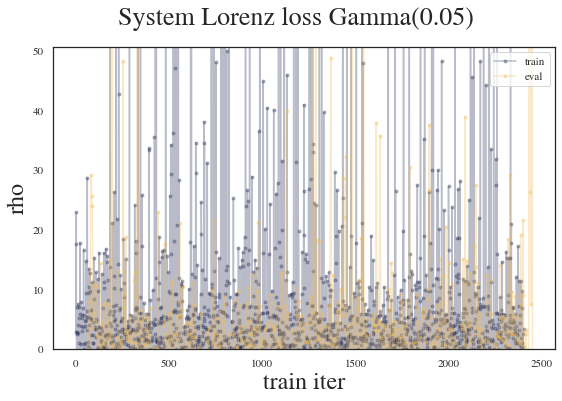

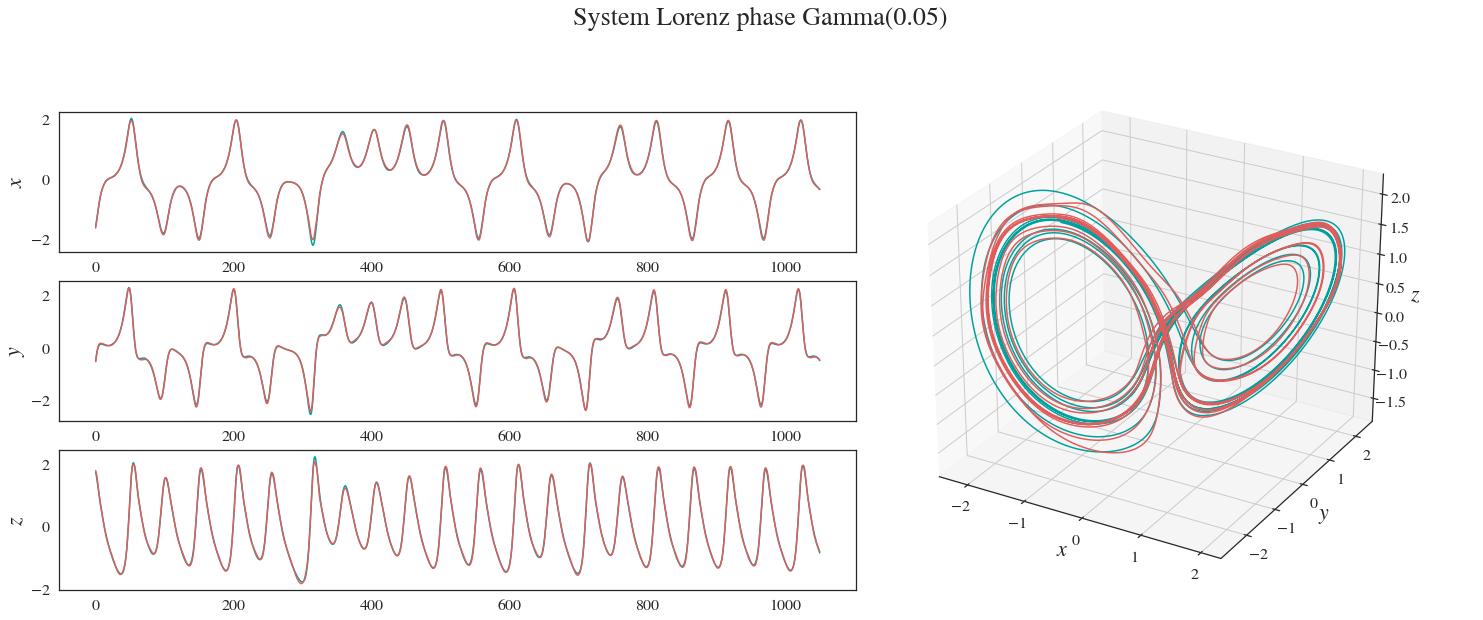

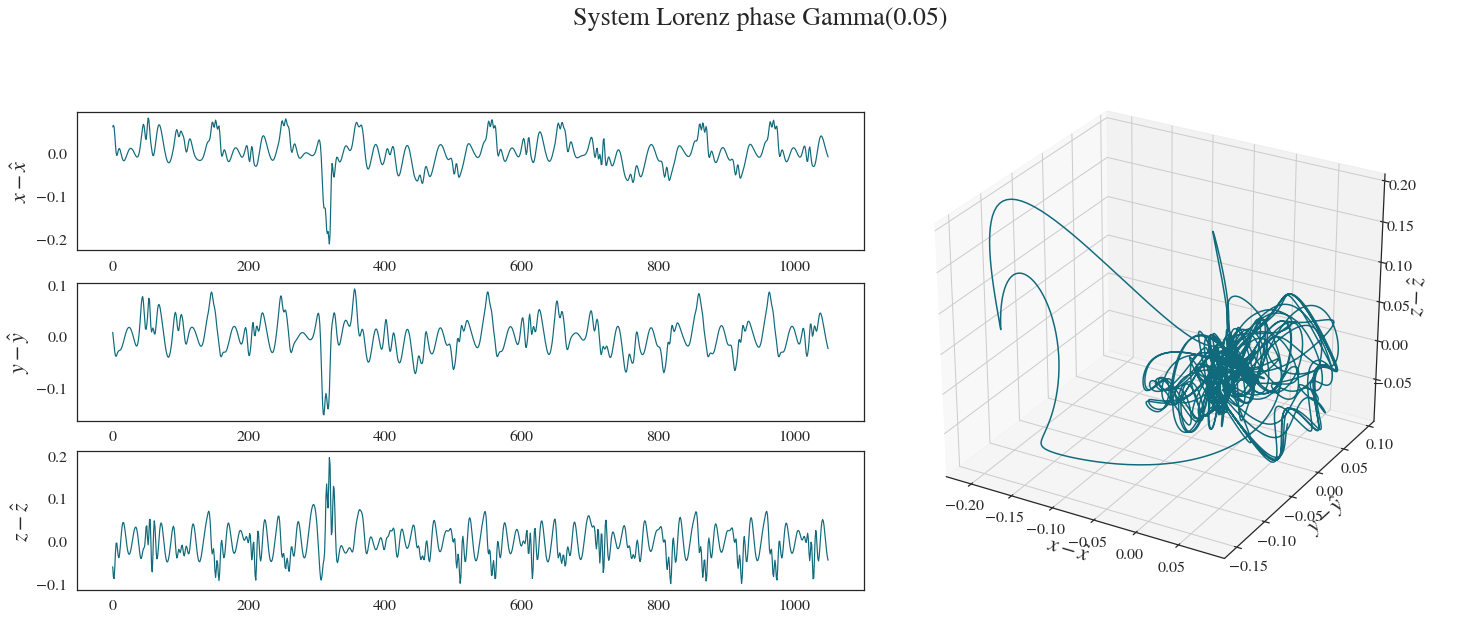

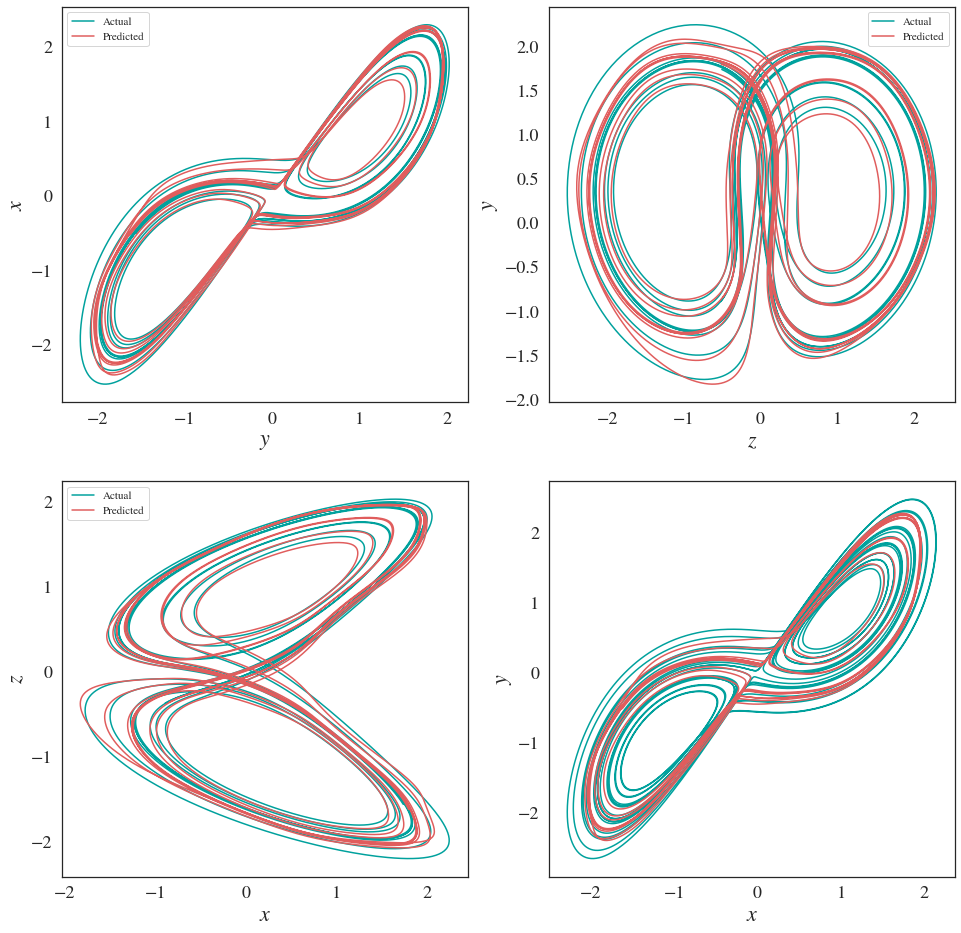

('sme', 0.0012555871)
('hausdorff', 0.2826672)
('smape', 0.08337962)


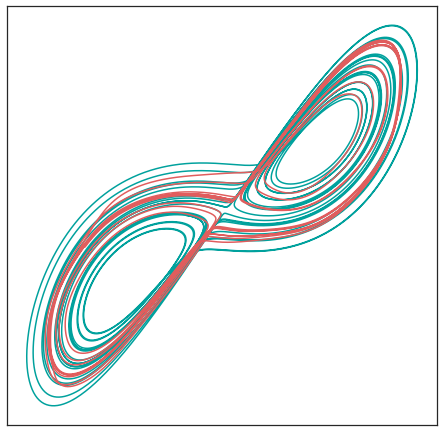

In [15]:
res_out(model=model,\
        pred_seq=pred_seq,\
        true_seq_ori_pre=true_seq_ori_pre,\
        true_seq_ori=true_seq_ori,\
        loss_dict=loss_dict,\
        sele_i=[15, 0],\
        CFG=CFG,\
        )